# MiBici: Data Retrival & Cleaning

The goal of this jupyter notebook is to collect and clean the datasets that'll be used for the exploratory data analysis and data visualizations of the MiBici biking-system.




# Import Libraries

In [1]:
# Web scraping libraries
import requests
import urllib.request
from bs4 import BeautifulSoup


# Downloading, moving and unzipping files
import webbrowser
from time import sleep
import shutil
import os
#from zipfile import ZipFile
import glob


# Reverse Geocode
#import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


# DataFrame exploration and manipulation
import pandas as pd
import numpy as np
import datetime as dt
import re


# Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme() # Apply the default theme

# MiBici Data

[MiBici]("https://www.mibici.net/es/datos-abiertos/") is Guadalajara's public bike sharing system in the state of Jalisco, Mexico. Their open data set contains monthly data files with information each nike trip taken with the system.

## Obtain MiBici Data Files

The code for obtaining the MiBici data files from their website is based on the code produced by Fausto De La Rosa Mañón for their analysis on the NYC Citibike dataset. The article for their analysis can be found on [Medium](https://medium.com/@fausto.manon/building-a-citibike-database-with-python-9849a59fb90c)
and the code on [GitHub](https://github.com/fmanon/Citibike_Trip_Data/blob/master/code/01_Create_Database.ipynb).

Request access to the MiBici Open Data webpage. `<Response [200]>` indicates that the request is successful.

In [2]:
url = 'https://www.mibici.net/es/datos-abiertos/'
response = requests.get(url, headers={"User-Agent": "XY"})
response

<Response [200]>

Parse the webpage using BeautifulSoup. This is to determine what HTML tag is used to identify the data files. 

In [3]:
soup = BeautifulSoup(response.text, 'xml')

The .csv files that we want are stored with an `/<a>` tag.

In [23]:
data_files = soup.find_all('a')

Edit the `data_files` variable to remove the non-data elements and the data files for 2022. 

In [24]:
data_files = data_files[35:106]

In [25]:
data_files

[<a href="/site/assets/files/1022/datos_abiertos_2017_01.csv"><li>Enero</li></a>,
 <a href="/site/assets/files/1111/datos_abiertos_2017_02.csv"><li>Febrero</li></a>,
 <a href="/site/assets/files/1112/datos_abiertos_2017_03.csv"><li>Marzo</li></a>,
 <a href="/site/assets/files/1115/datos_abiertos_2017_04-1.csv"><li>Abril</li></a>,
 <a href="/site/assets/files/1116/datos_abiertos_2017_05.csv"><li>Mayo</li></a>,
 <a href="/site/assets/files/1119/datos_abiertos_2017_06.csv"><li>Junio</li></a>,
 <a href="/site/assets/files/1120/datos_abiertos_2017_07.csv"><li>Julio</li></a>,
 <a href="/site/assets/files/1122/datos_abiertos_2017_08.csv"><li>Agosto</li></a>,
 <a href="/site/assets/files/1123/datos_abiertos_2017_09.csv"><li>Septiembre</li></a>,
 <a href="/site/assets/files/1124/datos_abiertos_2017_10.csv"><li>Octubre</li></a>,
 <a href="/site/assets/files/1197/datos_abiertos_2017_11.csv"><li>Noviembre</li></a>,
 <a href="/site/assets/files/1198/datos_abiertos_2017_12.csv"><li>Diciembre</li></a

Edit the `data_files` variable to get the data file name address.

In [26]:
def get_file_names(data_list):
    list = []
    for index in range(len(data_list)):
        list.append(data_list[index].attrs.get('href'))
    return list

In [27]:
data_files = get_file_names(data_files)

In [28]:
data_files

['/site/assets/files/1022/datos_abiertos_2017_01.csv',
 '/site/assets/files/1111/datos_abiertos_2017_02.csv',
 '/site/assets/files/1112/datos_abiertos_2017_03.csv',
 '/site/assets/files/1115/datos_abiertos_2017_04-1.csv',
 '/site/assets/files/1116/datos_abiertos_2017_05.csv',
 '/site/assets/files/1119/datos_abiertos_2017_06.csv',
 '/site/assets/files/1120/datos_abiertos_2017_07.csv',
 '/site/assets/files/1122/datos_abiertos_2017_08.csv',
 '/site/assets/files/1123/datos_abiertos_2017_09.csv',
 '/site/assets/files/1124/datos_abiertos_2017_10.csv',
 '/site/assets/files/1197/datos_abiertos_2017_11.csv',
 '/site/assets/files/1198/datos_abiertos_2017_12.csv',
 '/site/assets/files/1200/datos_abiertos_2018_01.csv',
 '/site/assets/files/1201/datos_abiertos_2018_02.csv',
 '/site/assets/files/1202/datos_abiertos_2018_03.csv',
 '/site/assets/files/1203/datos_abiertos_2018_04.csv',
 '/site/assets/files/1204/datos_abiertos_2018_05.csv',
 '/site/assets/files/1205/datos_abiertos_2018_06.csv',
 '/site/

Retreive all of the csv files from the website by iterating through each list item and leveraging the `webbrowser` library to open each respective download link.

In [29]:
url2 = 'https://www.mibici.net'
for file in data_files:
    webbrowser.open_new(url2 + file)
    sleep(60)

After downloading all of the respective files, relocate them from the `/Download` folder to the destination folder of the project.

In [30]:
source = 'C:/Users/Delan/Downloads/'
destination = '../../MiBici_Data/Original_BikeData/'

# Unzip files and clean up data folder
keywords = ['datos_abiertos', 'nomenclatura_2022']

# Move from Download folder to data folder
for item in os.listdir(source):
    for keyword in keywords:
        if keyword in item:
            shutil.move(source + item, destination)

Move the nomenclature file (with station data) to the parent folder.

In [31]:
source = '../../MiBici_Data/Original_BikeData/'
destination = '../../MiBici_Data/'

# Unzip files and clean up data folder
keywords = ['nomenclatura_2022']

# Move from Download folder to data folder
for item in os.listdir(source):
    for keyword in keywords:
        if keyword in item:
            shutil.move(source + item, destination)

## Fix Column Names

Check the details of the files, see what column headers they all share in common. 
* They share all have the same columns except the birth year of the rider.
* There is an issue with the `ñ` in the word `año` for the birth year variable between some files.

In [40]:
files = glob.glob(r'../../MiBici_Data/Original_BikeData/*.csv')

In [41]:
def get_common_columns(files, **kwargs):
    
    #Get set intersection of column-names of specified CSV files
    common_columns = set(pd.read_csv(files[0], nrows=0, **kwargs, encoding='latin-1').columns)
    
    for f in files[1:]:
        common_columns &= set(pd.read_csv(f, nrows=0, **kwargs, encoding='latin-1').columns)
    return common_columns

In [42]:
get_common_columns(files)

{'Destino_Id',
 'Fin_del_viaje',
 'Genero',
 'Inicio_del_viaje',
 'Origen_Id',
 'Usuario_Id',
 'Viaje_Id'}

Change column names and add additional variables to each file

In [43]:
# function to translate the columns names into English
def fix_colNames(data_frame):
    return data_frame.rename(columns=({'Viaje_Id'          :'Trip_ID',
                                       'Usuario_Id'        :'User_ID',
                                       'Genero'            :'Gender',
                                       'Año_de_nacimiento' :'Birth_Year',
                                       'AÃ±o_de_nacimiento':'Birth_Year',
                                 
                                       'Inicio_del_viaje' :'Start_Time',
                                       'Fin_del_viaje'    :'End_Time',
                                       'Origen_Id'        :'Start_Station_ID',
                                       'Destino_Id'       :'End_Station_ID'}
                             ))

In [44]:
# Function to convert start/end time variables into datetime objects and calculate the trip duration
def Create_DateTime(data_frame, index):
    
    data_frame['Start_Time'] = pd.to_datetime(data_frame['Start_Time'])
    data_frame['End_Time'] = pd.to_datetime(data_frame['End_Time'])
    data_frame['Duration'] = (data_frame['End_Time'] - data_frame['Start_Time']).dt.total_seconds()/60

    return data_frame

In [45]:
# Create more start time variables: hour of days, weekday, and month of trip
# 1 = Monday -> 7 = Sunday
def Create_StartVariables(data_frame):
    
    data_frame['Start_Hour']    = data_frame['Start_Time'].apply(lambda x: x.hour).astype('category')
    data_frame['Start_Month']   = data_frame['Start_Time'].apply(lambda x: x.month).astype('category')
    data_frame['Start_Weekday'] = data_frame['Start_Time'].apply(lambda x: x.isoweekday()).astype('category')
    data_frame['Start_Weekday'] = data_frame['Start_Weekday'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday',
                                                                   5:'Friday', 6:'Saturday', 7:'Sunday'})

    return data_frame

In [50]:
# obtain the csv data file names
oldPath = "../../MiBici_Data/Original_BikeData/"
newPath = "../../MiBici_Data/FirstCleaning/"
file_index = 1 # keep track of file count
temp_file_names = [os.path.basename(x) for x in glob.glob(oldPath+'*.csv')]

# Loop through each file, make changes, save in 'CleanData' folder
for file in temp_file_names:
    
    df = pd.read_csv(os.path.join(oldPath, file), encoding='latin-1')     # read in file as dataframe
    
    df = fix_colNames(df)                  # translate/rename columns
    df = Create_DateTime(df, file_index)   # Clean Start/End time variables. Create trip duration variable
    df = Create_StartVariables(df)         # obtain additional info on start_time: hour, weekday, month
    
    # Make a copy of the new formatted file into the 'CleanDataFolder'
    df.to_csv(newPath + file)
    
    file_index = file_index + 1

## Add Location Data

Reverse geolocating is used to obtain more detailed information about the locations of each bike station (e.g., town, neighborhood, etc.).

Read in the `all_stations_file` that contains the name, latitiude, and longitude information for each bike station

In [51]:
all_stations_df = pd.read_csv('../../MiBici_Data/nomenclatura_2022_10.csv', encoding='latin-1')

Take a peek at the dataframe.

In [52]:
all_stations_df.head()

,id,name,obcn,location,latitude,longitude,status
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE


Check for missing data.

In [53]:
all_stations_df.isnull().values.any()

False

Create a new variable that concatenates the latitude and longitude.

In [54]:
all_stations_df['geometry'] = all_stations_df['latitude'].map(str) + ',' + all_stations_df['longitude'].map(str)

In [55]:
all_stations_df.head(10)

,id,name,obcn,location,latitude,longitude,status,geometry
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882"
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366"
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252"
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255"
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863"
5,8,(GDL-006) C. Venustiano Carranza /C. Reforma,GDL-006,POLÍGONO CENTRAL,20.680717,-103.344415,IN_SERVICE,"20.680717,-103.344415"
6,9,(GDL-007) C. Epigmenio Glez./Av. Cristobal C.,GDL-007,POLÍGONO CENTRAL,20.666771,-103.350562,IN_SERVICE,"20.666771,-103.350562"
7,10,(GDL-008) C. J. Angulo / C. González Ortega,GDL-008,POLÍGONO CENTRAL,20.681871,-103.350396,IN_SERVICE,"20.681871,-103.350396"
8,11,(GDL-009) Calz. Federalismo/ C. J. Angulo,GDL-009,POLÍGONO CENTRAL,20.681984,-103.353835,IN_SERVICE,"20.681984,-103.353835"
9,12,(GDL-010) C. Cruz verde / C. Joaquin Angulo,GDL-010,POLÍGONO CENTRAL,20.681852,-103.357338,IN_SERVICE,"20.6818519,-103.3573381"


Reverse geolocate each station

In [56]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [57]:
from geopy.geocoders import Photon
locator = Photon(user_agent="measurements")

#locator = Nominatim(user_agent='myGeocoder', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [58]:
all_stations_df['address'] = all_stations_df['geometry'].apply(rgeocode)

In [59]:
all_stations_df.head()

,id,name,obcn,location,latitude,longitude,status,geometry,address
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Epigmenio González, 44180, Call..."
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias..."
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ..."
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G..."
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J..."


Check for missing address data.

In [60]:
all_stations_df.address.isnull().values.any()

False

Take a peek at the new address variable

In [61]:
all_stations_df.address[10].raw

{'geometry': {'coordinates': [-103.360048, 20.6810774], 'type': 'Point'},
 'type': 'Feature',
 'properties': {'osm_id': 4316576338,
  'country': 'México',
  'city': 'Guadalajara',
  'countrycode': 'MX',
  'postcode': '44200',
  'locality': 'Santa Tere',
  'type': 'house',
  'osm_type': 'N',
  'osm_key': 'amenity',
  'street': 'Calle Garibaldi',
  'osm_value': 'bicycle_rental',
  'name': 'MiBici',
  'state': 'Jalisco'}}

Extract the neighbourhood and city names for each bike station.

In [62]:
# neighborhood
all_stations_df.address[0].raw.get('properties').get('locality')

'Mexicaltzingo'

In [63]:
# city
all_stations_df['address'][0].raw.get('properties').get('city')

'Guadalajara'

In [64]:
all_stations_df['city']          = all_stations_df['address'].apply(lambda x : x.raw.get('properties').get('city'))
all_stations_df['neighbourhood'] = all_stations_df['address'].apply(lambda x : x.raw.get('properties').get('locality'))

In [65]:
all_stations_df.head(5)

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Epigmenio González, 44180, Call...",Guadalajara,Mexicaltzingo
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias...",Guadalajara,Americana
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ...",Guadalajara,Obrera
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G...",Guadalajara,Mezquitán Country
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J...",Guadalajara,La Perla


Check unique values for city & neighborhoods

In [66]:
set(all_stations_df.city)

{'Guadalajara', 'Guadalajara, Jalisco', None, 'Tlaquepaque', 'Zapopan'}

In [67]:
set(all_stations_df.neighbourhood)

{'Americana',
 'Analco',
 'Arcos Vallarta',
 'Barranquitas',
 'Barrio de Mezquitán',
 'Belenes Norte',
 'Camino Real',
 'Capilla de Jesús',
 'Centro Barranquitas',
 'Chapalita',
 'Chapalita Oriente',
 'Chapultepec Country',
 'Circunvalación',
 'Circunvalación Guevara',
 'Ciudad de los Niños',
 'Ciudad del Sol',
 'Colinas de la Normal',
 'Colonia del Periodista',
 'Country Plaza',
 'Don Bosco Vallarta',
 'El Capullo',
 'El Vigía',
 'Guadalajara Centro',
 'Guadalupe',
 'Hacendarios',
 'Ibarra y Molodom',
 'Independencia Oriente',
 'Independencia Sur',
 'Industrial Los Belenes',
 'Italia',
 'Jacarandas',
 'Jardines de Los Arcos 1a Sección',
 'Jardines de San Ignacio',
 'Jardines del Bosque',
 'Jardines del Bosque Norte',
 'Jardines del Country',
 'Juan Diego',
 'La Normal',
 'La Perla',
 'Ladrón de Guevara',
 'Las Flores',
 'Las Nueve Esquinas',
 'Laureles',
 'Loma Blanca',
 'Los Maestros',
 'Mexicaltzingo',
 'Mezquitán',
 'Mezquitán Country',
 'Miraflores',
 'Moderna',
 None,
 'Obrera',


Truncate city name from `Guadalajara, Jalisco` to `Guadalajara`

In [69]:
# Only one item is listed as 'Guadalajara, Jalisco'
sum(all_stations_df['city'] == 'Guadalajara, Jalisco')

1

In [72]:
all_stations_df.loc[all_stations_df['city'] == 'Guadalajara, Jalisco', 'city'] = 'Guadalajara'

Check for missing data:
* Rows with missing neighborhood data are manually corrected.

In [73]:
all_stations_df.isnull().values.any()

True

In [74]:
all_stations_df.isnull().sum()

id                0
name              0
obcn              0
location          0
latitude          0
longitude         0
status            0
geometry          0
address           0
city              1
neighbourhood    29
dtype: int64

Remove text in parenthesis in name column

In [78]:
all_stations_df.head(5)

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Epigmenio González, 44180, Call...",Guadalajara,Mexicaltzingo
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias...",Guadalajara,Americana
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ...",Guadalajara,Obrera
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G...",Guadalajara,Mezquitán Country
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J...",Guadalajara,La Perla


In [90]:
all_stations_df['name'] = all_stations_df['name'].str.split(')').str[1]

In [99]:
all_stations_df

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
0,2,C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Epigmenio González, 44180, Call...",Guadalajara,Mexicaltzingo
1,3,C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias...",Guadalajara,Americana
2,4,C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ...",Guadalajara,Obrera
3,5,C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G...",Guadalajara,Mezquitán Country
4,6,C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J...",Guadalajara,La Perla
...,...,...,...,...,...,...,...,...,...,...,...
307,323,C. Palavicini / Av. Circunvalación,GDL-213,POLÍGONO CENTRAL,20.704670,-103.345589,IN_SERVICE,"20.70467,-103.345589","(Calle Félix Palavicini, 44220, Guadalajara, J...",Guadalajara,Ibarra y Molodom
308,324,De los científicos/ J. J. Tablada,GDL-221,POLÍGONO CENTRAL,20.700192,-103.345961,IN_SERVICE,"20.700192,-103.345961","(823, Avenida de los Científicos, 44266, Aveni...",Guadalajara,Miraflores
309,325,C. Luis G. Cuevas /Av. Revolución,GDL-226,TLQ-CORREDORATLAS,20.652408,-103.312902,IN_SERVICE,"20.652408,-103.312902","(2126, Avenida Revolución, 44410, Avenida Revo...",Guadalajara,None
310,326,C. D. Rivera / C. Filósofos,GDL-219,POLÍGONO CENTRAL,20.698197,-103.342554,IN_SERVICE,"20.698197,-103.342554","(Calle Paseo de los Filósofos, Calle Paseo de ...",Guadalajara,Colinas de la Normal


Save the modified data frame to the project folder

In [ ]:
# all_stations_df.to_csv('../../MiBici_Data/nomenclatura_2022_10_updated.csv', index=False, encoding = 'utf-8')

## Combine Station/Main Datasets

Read in new bike station dataset

In [127]:
# Location station dataset
all_stations_new_df = pd.read_csv('../../MiBici_Data/nomenclatura_2022_10_updated.csv', encoding='utf-8')

In [129]:
# Check to make sure formatting is OK
all_stations_new_df.tail(5)

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
307,323,C. Palavicini / Av. Circunvalación,GDL-213,POLÍGONO CENTRAL,20.704670,-103.345589,IN_SERVICE,"20.70467,-103.345589","Calle Félix Palavicini, 44220, Guadalajara, Ja...",Guadalajara,Ibarra y Molodom
308,324,De los científicos/ J. J. Tablada,GDL-221,POLÍGONO CENTRAL,20.700192,-103.345961,IN_SERVICE,"20.700192,-103.345961","823, Avenida de los Científicos, 44266, Avenid...",Guadalajara,Miraflores
309,325,C. Luis G. Cuevas /Av. Revolución,GDL-226,TLQ-CORREDORATLAS,20.652408,-103.312902,IN_SERVICE,"20.652408,-103.312902","2126, Avenida Revolución, 44410, Avenida Revol...",Guadalajara,Sutaj
310,326,C. D. Rivera / C. Filósofos,GDL-219,POLÍGONO CENTRAL,20.698197,-103.342554,IN_SERVICE,"20.698197,-103.342554","Calle Paseo de los Filósofos, Calle Paseo de l...",Guadalajara,Colinas de la Normal
311,327,C. Artistas / C. Carlos Pereira,GDL-227,POLÍGONO CENTRAL,20.695636,-103.339378,IN_SERVICE,"20.695636,-103.339378","402, Calle Carlos Pereira, 44290, Calle Carlos...",Guadalajara,Barranquitas


Loop through each station type (start/end) and merge location data to full dataset

In [130]:
def CombineLocation(full_df, location_df):
    
    # Set indices of both dataframes for start Locations
    full_df.set_index('Start_Station_ID', drop=False, inplace=True) # Set full dataset index to start index
    location_df.set_index('id', drop=False, inplace=True)           # Set location dataset index to 'id' index

    # Merge location to full dataset
    full_df = pd.merge(full_df, location_df.drop(['id', 'obcn', 'location'], axis=1), left_index=True, right_index=True, how='left')

    # Rename new columns for start locations 
    full_df.rename(columns=({'name'          : 'Start_Name',
                             'latitude'      : 'Start_Latitude',  
                             'longitude'     : 'Start_Longitude',
                             'status'        : 'Start_Status',
                             'geometry'      : 'Start_Geometry',
                             'address'       : 'Start_Address',
                             'city'          : 'Start_City',
                             'neighbourhood' : 'Start_Neighborhood'}
                            ), inplace=True)
    
    # Set indices of both dataframes for start Locations
    full_df.set_index('End_Station_ID', drop=False, inplace=True) # Set full dataset index to start index

    # Merge location to full dataset
    full_df = pd.merge(full_df, location_df.drop(['id', 'obcn', 'location'], axis=1), left_index=True, right_index=True, how='left')

    # Rename new columns for start locations 
    full_df.rename(columns=({'name'          : 'End_Name',
                             'latitude'      : 'End_Latitude',  
                             'longitude'     : 'End_Longitude',
                             'status'        : 'End_Status',
                             'geometry'      : 'End_Geometry',
                             'address'       : 'End_Address',
                             'city'          : 'End_City',
                             'neighbourhood' : 'End_Neighborhood'}
                            ), inplace=True)
    return full_df
    

In [137]:
# obtain the csv data file names
oldPath = "../../MiBici_Data/FirstCleaning/"
newPath = "../../MiBici_Data/SecondCleaning/"
files = [os.path.basename(x) for x in glob.glob('../../MiBici_Data/FirstCleaning/*.csv')]

# Loop through each file, make changes, save in 'SecondCleaning' folder
for file in files:
    
    df = pd.read_csv(os.path.join(oldPath, file), encoding='utf-8')           # read in file as dataframe
    df = CombineLocation(df, all_stations_new_df)                               # add bike station data
    df.iloc[:, 1:].to_csv(newPath + file, index=False, encoding = 'utf-8')    # Make a copy of the new formatted file into the 'SecondCleaning' without extrax index column

# Missing Data

Upload data and separate into data frames by year

In [35]:
# obtain the csv data file names
path = "../../MiBici_Data/SecondCleaning/"
files = [file for file in os.listdir(path) if file.endswith(".csv")]

In [36]:
# Loop through each file, check what year its from, save in appropriate dataframe
MiBici2017 = pd.DataFrame()
MiBici2018 = pd.DataFrame()
MiBici2019 = pd.DataFrame()
MiBici2020 = pd.DataFrame()
MiBici2021 = pd.DataFrame()
MiBici2022 = pd.DataFrame()

for file in files:
    if file[15:19] == '2017':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2017 = pd.concat([MiBici2017, df_temp], axis=0)
        
    elif file[15:19] == '2018':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2018 = pd.concat([MiBici2018, df_temp], axis=0)
        
    elif file[15:19] == '2019':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2019 = pd.concat([MiBici2019, df_temp], axis=0)
        
    elif file[15:19] == '2020':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2020 = pd.concat([MiBici2020, df_temp], axis=0)
        
    elif file[15:19] == '2021':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2021 = pd.concat([MiBici2021, df_temp], axis=0)
    
    elif file[15:19] == '2022':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2022 = pd.concat([MiBici2022, df_temp], axis=0)

Check for missing data
* Rides with missing Gender & Birth Year data will not be deleted
* Rows with missing location-related data, are not missing all the same data

In [37]:
pd.concat([MiBici2017.isna().sum(),
           MiBici2018.isna().sum(),
           MiBici2019.isna().sum(),
           MiBici2020.isna().sum(),
           MiBici2021.isna().sum(),
           MiBici2022.isna().sum()], axis=1)

,0,1,2,3,4,5
Trip_ID,0,0,0,0,0,0
User_ID,0,0,0,0,0,0
Gender,0,0,6415,3349,4832,14888
Birth_Year,12752,11621,11522,3447,4332,13092
Start_Time,0,0,0,0,0,0
End_Time,0,0,0,0,0,0
Start_Station_ID,0,0,0,0,0,0
End_Station_ID,0,0,0,0,0,0
Duration,0,0,0,0,0,0
Start_Hour,0,0,0,0,0,0


Further investigate rides with missing location-related data

In [38]:
MiBici2019[MiBici2019['End_Latitude'].isna()]

,Trip_ID,User_ID,Gender,Birth_Year,Start_Time,End_Time,Start_Station_ID,End_Station_ID,Duration,Start_Hour,...,Start_City,Start_Neighborhood,End_Name,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood
222559,9203980,461651,F,1984.0,2019-01-22 12:59:14,2019-01-22 13:09:05,57,124,9.850000,12,...,Guadalajara,Las Nueve Esquinas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222560,9281028,375312,M,2001.0,2019-01-26 14:15:45,2019-01-26 14:30:31,60,124,14.766667,14,...,Guadalajara,Las Nueve Esquinas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222561,9283217,244263,F,1994.0,2019-01-26 16:42:19,2019-01-26 16:46:37,69,124,4.300000,16,...,Guadalajara,Mexicaltzingo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222562,9280457,330512,F,1991.0,2019-01-26 13:47:18,2019-01-26 14:06:40,87,124,19.366667,13,...,Guadalajara,Obrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222563,9280458,254240,F,1983.0,2019-01-26 13:47:24,2019-01-26 14:07:14,87,124,19.833333,13,...,Guadalajara,Obrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222564,9280461,226501,M,1993.0,2019-01-26 13:47:31,2019-01-26 14:05:50,87,124,18.316667,13,...,Guadalajara,Obrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222565,9185846,471777,M,1972.0,2019-01-21 14:05:23,2019-01-21 14:05:39,124,124,0.266667,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222566,9232978,307675,F,1993.0,2019-01-23 19:38:09,2019-01-23 19:38:20,124,124,0.183333,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222567,9232992,307675,F,1993.0,2019-01-23 19:38:33,2019-01-23 19:38:41,124,124,0.133333,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222568,9277390,335131,F,1989.0,2019-01-26 10:18:33,2019-01-26 10:19:17,124,124,0.733333,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean Trip Duration

Summary Statistics
* Each year has trip durations over 100 hrs long
* These are likely not true trips (stolen bike, uncorrectly parked, etc.)

In [39]:
pd.concat([MiBici2017.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2018.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2019.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2020.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2021.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2022.Duration.describe().apply(lambda x: '%.2f' % x)
          ], axis=1)

,Duration,Duration,Duration,Duration,Duration,Duration
count,2516534.00,3403485.00,4636652.00,2866072.00,3184410.00,3499198.00
mean,38.57,11.45,11.53,11.33,11.02,10.77
std,1891.91,109.93,98.86,27.37,26.87,8.97
min,0.00,0.00,0.02,0.00,0.00,0.00
25%,5.83,5.82,5.85,5.82,5.70,5.55
50%,9.42,9.43,9.55,9.63,9.48,9.30
75%,14.63,14.60,14.80,14.87,14.72,14.57
max,629228.77,125404.75,118583.15,24783.35,28150.77,2754.52


Check the histograms and percentiles of the trip duration column

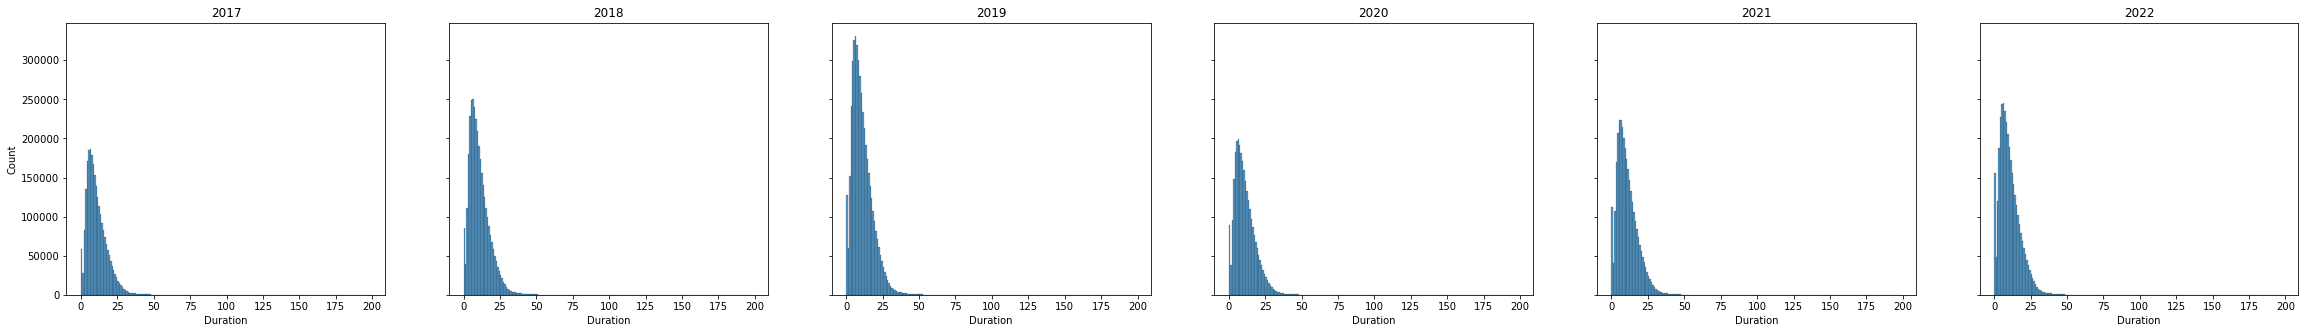

In [40]:
# Loop through each dataset and create its plot
years_df = [MiBici2017, MiBici2018, MiBici2019, MiBici2020, MiBici2021, MiBici2022]
years = ['2017', '2018', '2019', '2020', '2021', '2022']

fig, axs = plt.subplots(ncols=6, figsize=(40, 5), sharey=True)
for i in range(len(years)):
    sns.histplot(years_df[i]['Duration'], bins=range(0, 200, 1),  ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

In [41]:
# the 99.8% percentile makes the most sense to use (all rides < roughly 2 hrs)
quantiles = [.99, .9975, .998, .9985, .999]

pd.DataFrame([[round(years_df[i].Duration.quantile(quantiles[n]), 4) for i in range(len(years))] \
              for n in range(len(quantiles))],
             columns=years, index = quantiles)

,2017,2018,2019,2020,2021,2022
0.9900,34.8167,33.7833,33.8167,33.0333,32.6152,32.3667
0.9975,78.1222,54.4333,51.5833,47.5333,43.9833,43.4500
0.9980,100.6634,62.5500,58.4000,51.9476,46.4667,45.6500
0.9985,147.5734,79.1462,71.9500,59.6316,50.4231,49.2500
0.9990,266.6989,111.7919,106.4283,77.7667,57.6167,55.8634


Remove the trips that have a trip duration larger than the 99% percentile

In [42]:
MiBici2017 = MiBici2017[MiBici2017.Duration <= MiBici2017.Duration.quantile(.998)]
MiBici2018 = MiBici2018[MiBici2018.Duration <= MiBici2018.Duration.quantile(.998)]
MiBici2019 = MiBici2019[MiBici2019.Duration <= MiBici2019.Duration.quantile(.998)]
MiBici2020 = MiBici2020[MiBici2020.Duration <= MiBici2020.Duration.quantile(.998)]
MiBici2021 = MiBici2021[MiBici2021.Duration <= MiBici2021.Duration.quantile(.998)]

Remove trips with a duration less than 1.5 minutes

In [43]:
MiBici2017 = MiBici2017[MiBici2017.Duration >= 1.5]
MiBici2018 = MiBici2018[MiBici2018.Duration >= 1.5]
MiBici2019 = MiBici2019[MiBici2019.Duration >= 1.5]
MiBici2020 = MiBici2020[MiBici2020.Duration >= 1.5]
MiBici2021 = MiBici2021[MiBici2021.Duration >= 1.5]

New Summary Statistics

In [44]:
pd.concat([MiBici2017.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2018.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2019.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2020.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2021.Duration.describe().apply(lambda x: '%.2f' % x)
          ], axis=1)

,Duration,Duration,Duration,Duration,Duration
count,2445638.00,3299857.00,4480232.00,2758939.00,3053133.00
mean,11.23,11.18,11.31,11.34,11.23
std,7.19,6.82,6.85,6.77,6.69
min,1.50,1.50,1.50,1.50,1.50
25%,6.08,6.10,6.17,6.20,6.12
50%,9.62,9.65,9.80,9.92,9.80
75%,14.78,14.75,14.98,15.07,14.95
max,100.62,62.55,58.40,51.93,46.47


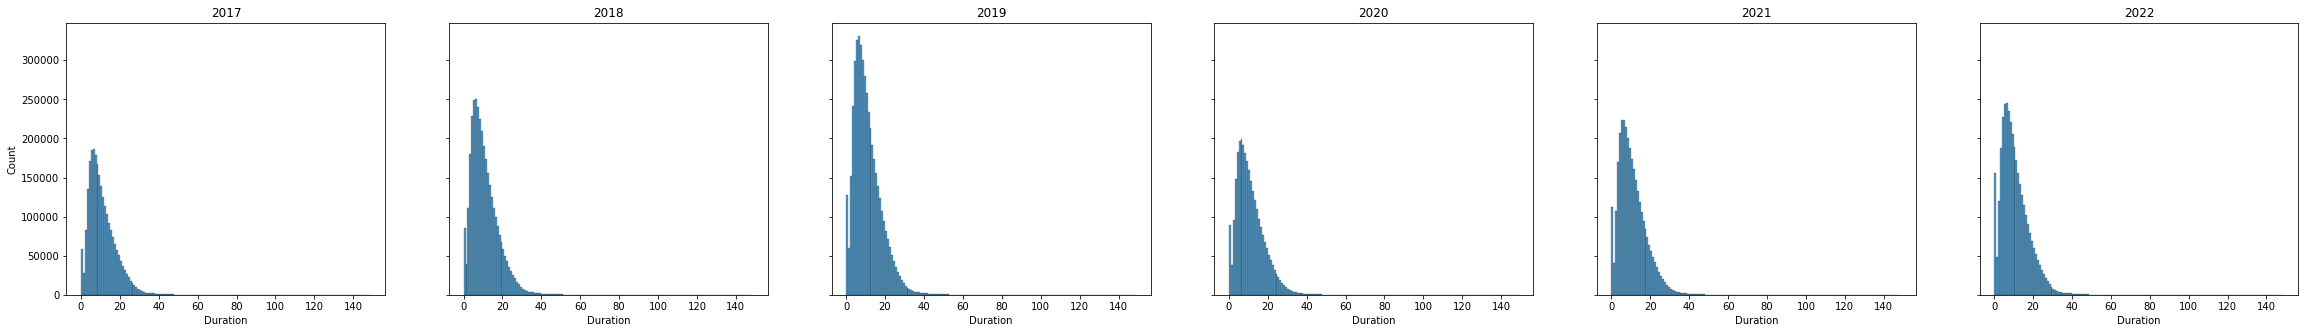

In [45]:
# Loop through each dataset and create its plot
fig, axs = plt.subplots(ncols=6, figsize=(40, 5), sharey=True)
for i in range(len(years)):
    sns.histplot(years_df[i]['Duration'], bins=range(0,150,1), ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

# Summary Statistics

## Trip Counts

In [46]:
tripCount_df = pd.DataFrame([len(MiBici2017),
                             len(MiBici2018),
                             len(MiBici2019),
                             len(MiBici2020),
                             len(MiBici2021),
                             len(MiBici2022)],
                            columns=['Count'],
           index=years)
tripCount_df

,Count
2017,2445638
2018,3299857
2019,4480232
2020,2758939
2021,3053133
2022,3499198


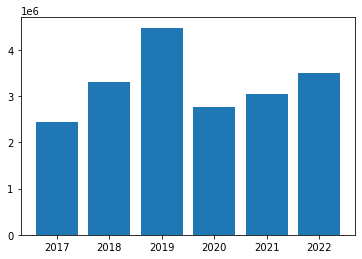

In [47]:
plt.bar(tripCount_df.index, tripCount_df.Count)
plt.show()

In [125]:
pd.DataFrame([years_df[i].groupby(["Start_City"]).size().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

Start_City,Guadalajara,Tlaquepaque,Zapopan
2017,2301672,43898,100062
2018,3109198,60444,130215
2019,4160350,73177,246697
2020,2544840,46981,167115
2021,2768083,49003,236047
2022,3152455,50657,296086


<AxesSubplot:>

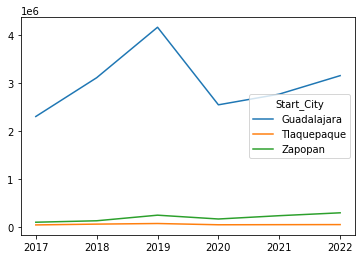

In [124]:
pd.DataFrame([years_df[i].groupby(["Start_City"]).size().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years).astype(int).plot()

## Gender

In [48]:
# Statistics
pd.DataFrame([years_df[i].Gender.astype('category').describe(include='category') \
              for i in range(len(years)) 
             ], index=years)

,count,unique,top,freq
2017,2516534,2,M,1899924
2018,3403485,2,M,2543132
2019,4630237,2,M,3439925
2020,2862723,2,M,2114951
2021,3179578,2,M,2315220
2022,3484310,2,M,2536389


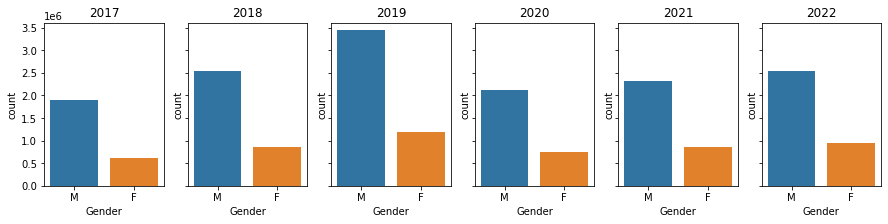

In [49]:
# Loop through each dataset and create its plot
fig, axs = plt.subplots(ncols=6, figsize=(15, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x = 'Gender', data = years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

## Birth Year

In [50]:
# Statistics
pd.DataFrame([years_df[i].Birth_Year.describe().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,mean,std,min,25%,50%,75%,max
2017,2503782,1985,10,1917,1981,1988,1992,2001
2018,3391864,1986,10,1917,1982,1989,1993,2002
2019,4625130,1987,10,1917,1982,1990,1994,2003
2020,2862625,1987,10,1917,1982,1990,1994,2003
2021,3180078,1987,25,1,1982,1990,1995,2021
2022,3486106,1988,21,1,1984,1991,1996,2022


2021 & 20222 datasets:
* Replace Birth year < 1917 with NaN (like all other years)
* Replace Birth year > 2005 & 2006 with NaN (like all other years, youngest rides are 16 yrs old because this is the youngest age an user can get a subscription [MiBici](https://www.mibici.net/es/preguntas-frecuentes/)


In [51]:
MiBici2021['Birth_Year'] = MiBici2021.Birth_Year.mask(MiBici2021.Birth_Year > 2005)
MiBici2021['Birth_Year'] = MiBici2021.Birth_Year.mask(MiBici2021.Birth_Year < 1917)

MiBici2022['Birth_Year'] = MiBici2022.Birth_Year.mask(MiBici2022.Birth_Year > 2006)
MiBici2022['Birth_Year'] = MiBici2022.Birth_Year.mask(MiBici2022.Birth_Year < 1917)

In [52]:
# Check stats again
years_df = [MiBici2017, MiBici2018, MiBici2019, MiBici2020, MiBici2021, MiBici2022]

pd.DataFrame([years_df[i].Birth_Year.describe().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,mean,std,min,25%,50%,75%,max
2017,2434038,1985,10,1917,1981,1988,1992,2001
2018,3289613,1986,10,1917,1982,1989,1993,2002
2019,4470149,1987,10,1917,1982,1990,1994,2003
2020,2756023,1987,10,1917,1981,1990,1994,2003
2021,3048556,1987,10,1918,1982,1990,1995,2005
2022,3485294,1989,10,1920,1984,1991,1996,2006


## Age

Calculate age from birth year

In [53]:
for i in range(len(years)):
    years_df[i]['Age'] = int(years[i]) - years_df[i].Birth_Year

In [54]:
# Move age column next to birth year column
for yr in years_df:
    column_to_move = yr.pop("Age")
    yr.insert(4, "Age", column_to_move)

Age stats:
* The most common rider age (mode) was 27, 26, 25, 26, 27 years respectively
* The mean ages are betwwn 32-34 years
* Median age is between 29-31 years

In [55]:
# stats as integers
pd.DataFrame([years_df[i].Age.describe().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,mean,std,min,25%,50%,75%,max
2017,2434038,32,10,16,25,29,36,100
2018,3289613,32,10,16,25,29,36,101
2019,4470149,32,10,16,25,29,37,102
2020,2756023,33,10,17,26,30,39,103
2021,3048556,34,10,16,26,31,39,103
2022,3485294,33,10,16,26,31,38,102


In [56]:
# stats as categories
pd.DataFrame([years_df[i].Age.astype('category').describe(include='category').apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,unique,top,freq
2017,2434038,67,27,167421
2018,3289613,70,26,214087
2019,4470149,71,25,270962
2020,2756023,69,26,157156
2021,3048556,70,27,169734
2022,3485294,69,26,208326


Categorize ages into bins

In [60]:
for i in range(len(years)):
    years_df[i]['Age_category'] = pd.cut(years_df[i]['Age'], 
                                         bins = [0,20,30,40,50,60,70,80,200], 
                                         labels = ["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80+"], 
                                         include_lowest=True)

Statistics & Plot

In [62]:
pd.DataFrame([years_df[i].Age_category.describe() \
              for i in range(len(years)) 
             ], index=years)

,count,unique,top,freq
2017,2434038,8,20s,1285966
2018,3289613,8,20s,1746270
2019,4470149,8,20s,2306069
2020,2756023,8,20s,1299905
2021,3048556,8,20s,1378080
2022,3485294,8,20s,1600350


In [ ]:
# Move age column next to borth year column
fig, axs = plt.subplots(ncols=6, figsize=(20, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x="Age_category", data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

## Age by Gender

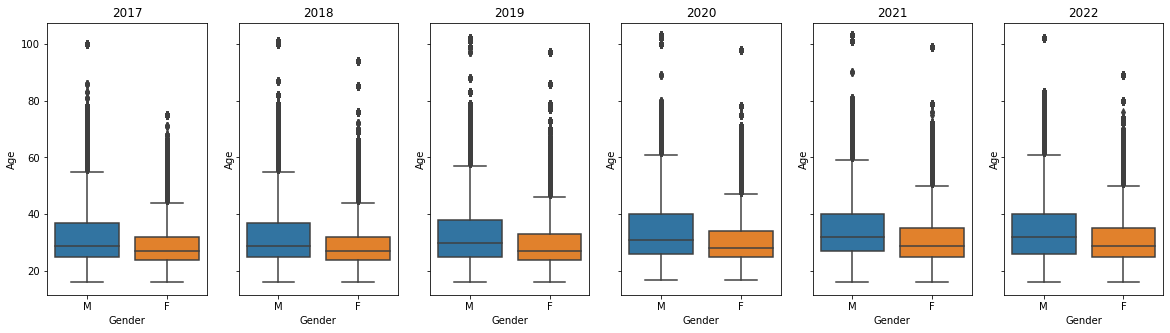

In [66]:
fig, axs = plt.subplots(ncols=6, figsize=(20, 5), sharey=True)
for i in range(len(years)):
    sns.boxplot(x="Gender", y="Age",  data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

## Day of the Week

Most popular day to use the system (Monday-Wednesday)

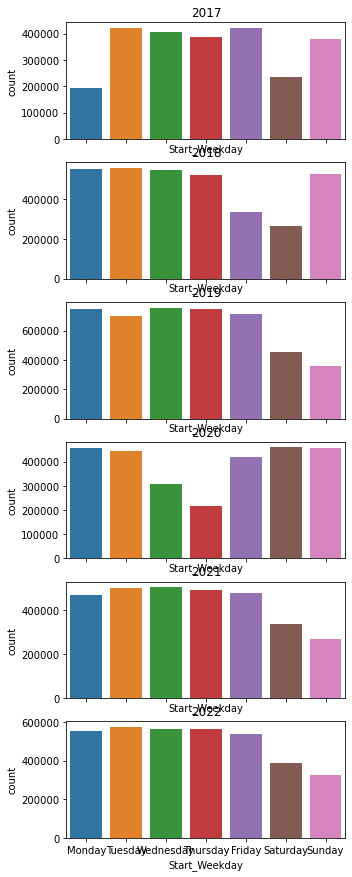

In [175]:
# 1 = Monday -> 7 = Sunday
weekday_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(nrows=6, figsize=(5, 15), sharex=True)
for i in range(len(years)):
    sns.countplot(x="Start_Weekday", data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])

plt.show()

Most popular hour to use the system 
* 8AM and 6 PM (rush hour: commuting times)
* 2PM (perhaps when school ends)

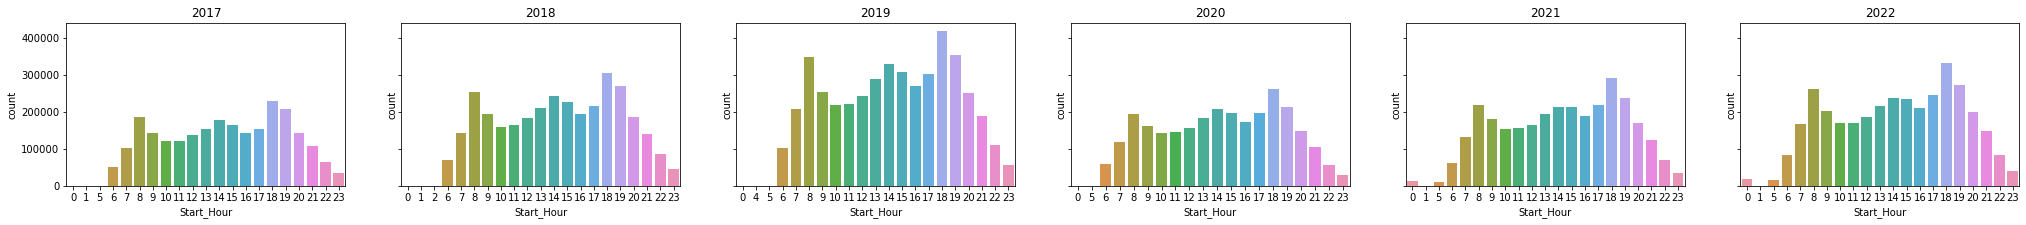

In [78]:
fig, axs = plt.subplots(ncols=6, figsize=(35, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x="Start_Hour", data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

Hour distribution by day of the week

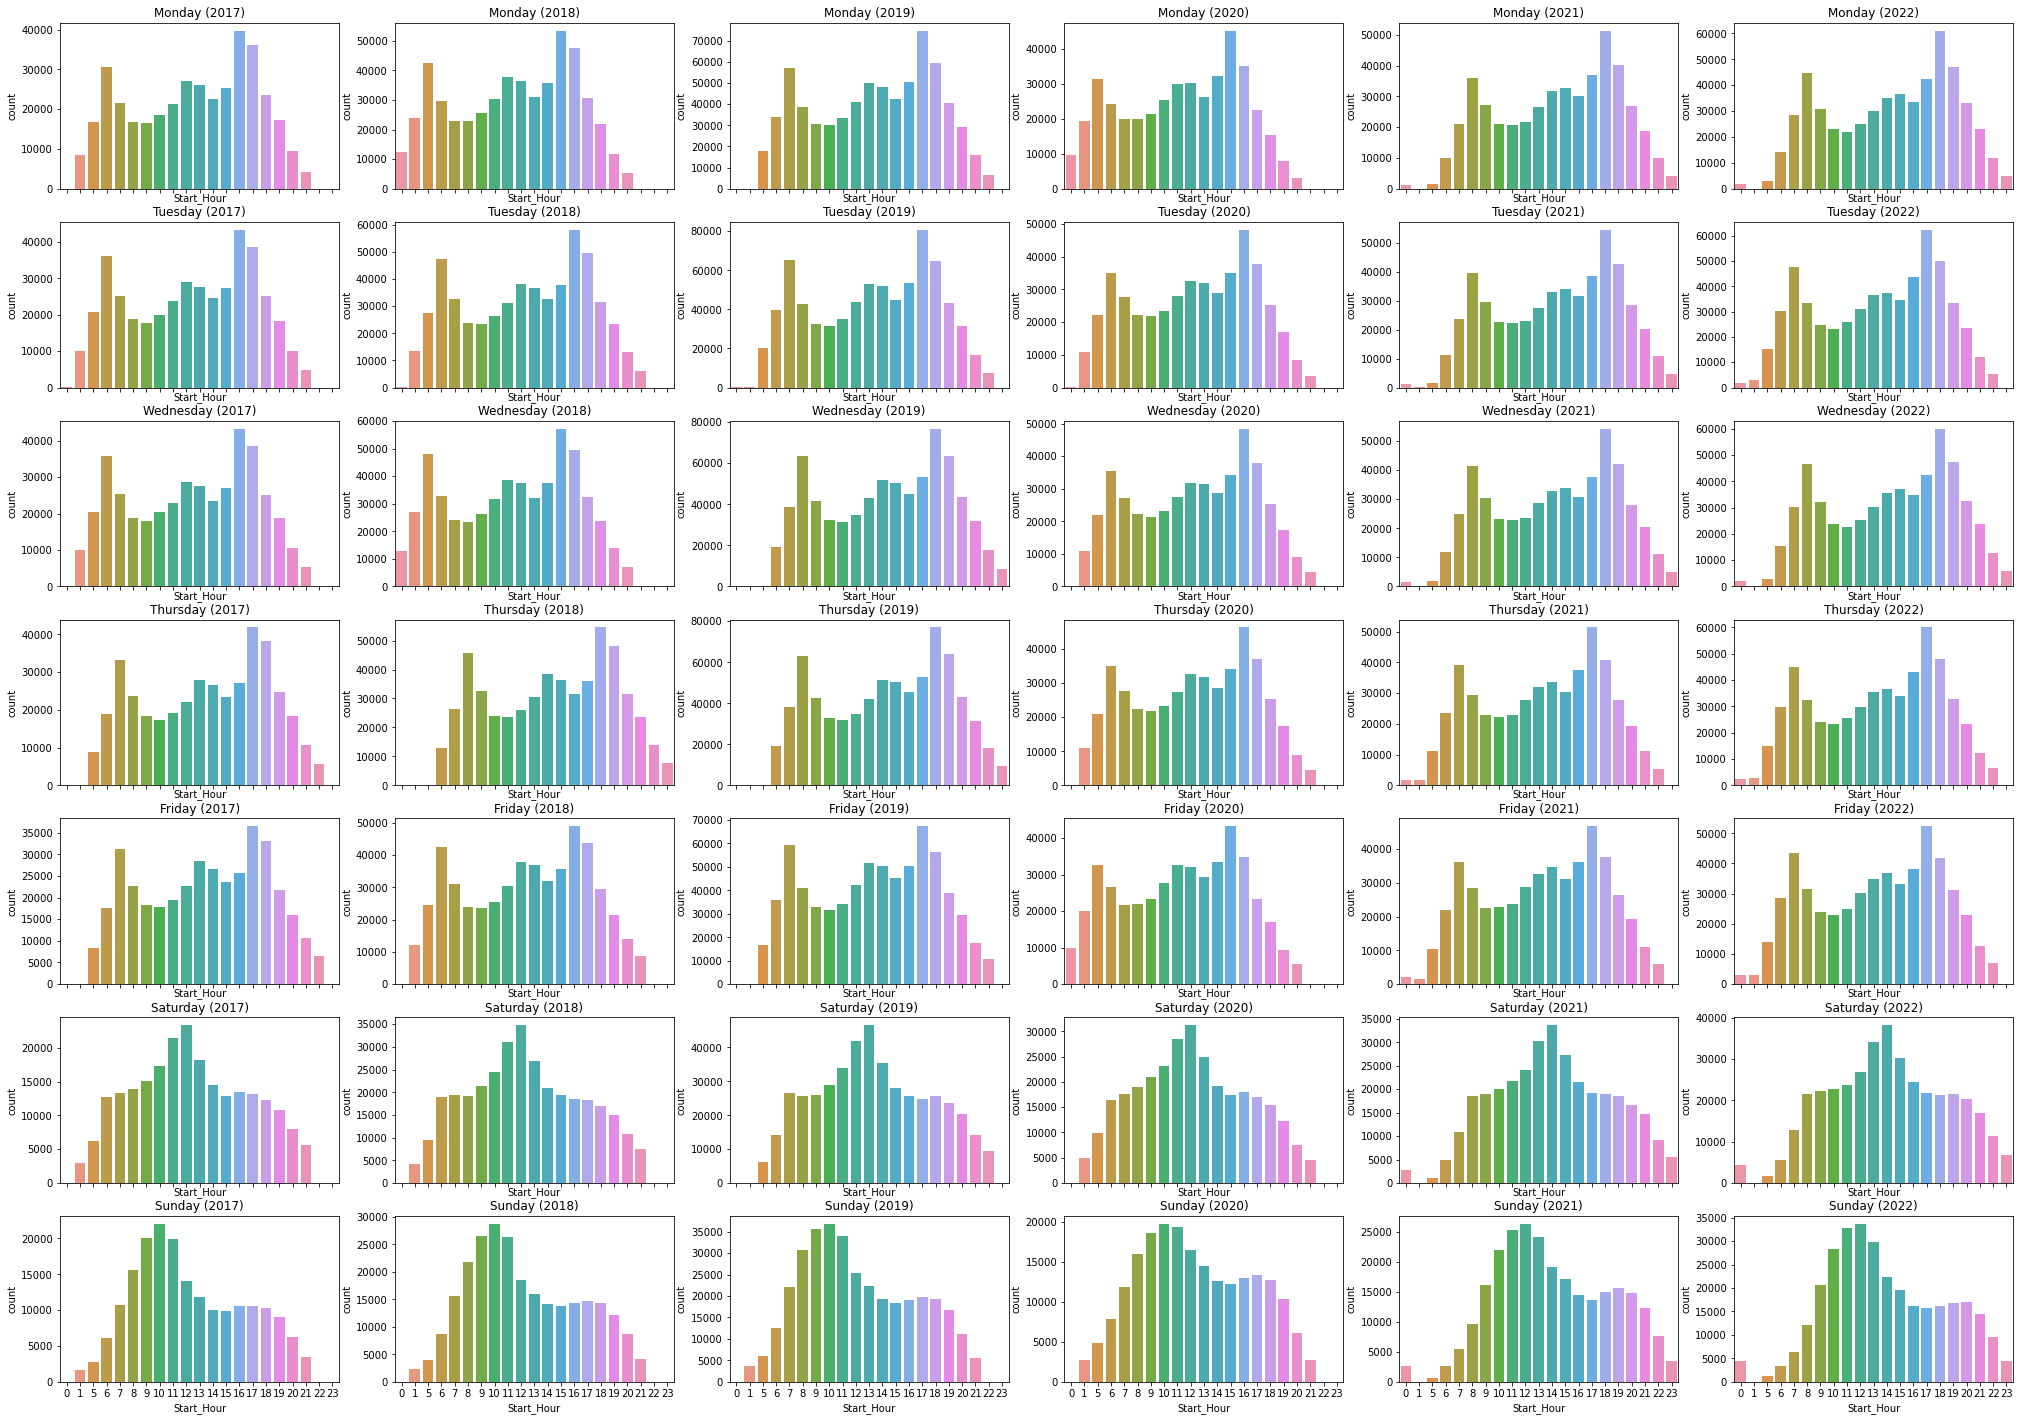

In [83]:
fig, axs = plt.subplots(nrows=7, ncols=6, figsize=(35, 25), sharex=True, sharey=False)
for i in range(len(years)):
    for j in range(len(weekday_name)):        
        sns.countplot(x="Start_Hour", 
                      data=years_df[i][years_df[i].Start_Weekday == weekday_name[j]], 
                      ax=axs[j,i])
        axs[j,i].set_title(weekday_name[j]+' ('+years[i]+')')
plt.show()

Trip duration by day of the week

In [93]:
# annual mean by week day
pd.DataFrame([[years_df[i][years_df[i]['Start_Weekday'] == weekday_name[j]]['Duration'].mean() for i in range(len(years))] \
              for j in range(len(weekday_name))],
             columns=years, index = weekday_name).round(2)

,2017,2018,2019,2020,2021,2022
Monday,11.02,10.96,11.12,11.20,11.06,10.55
Tuesday,11.02,11.00,11.12,11.28,11.06,10.56
Wednesday,11.04,11.01,11.15,11.26,11.07,10.58
Thursday,10.98,10.99,11.11,11.22,11.03,10.51
Friday,11.03,11.03,11.16,11.25,11.04,10.55
Saturday,11.09,11.04,11.22,11.36,11.15,10.66
Sunday,13.60,13.21,13.26,12.37,12.96,12.83


In [94]:
# annual median by week day
pd.DataFrame([[years_df[i][years_df[i]['Start_Weekday'] == weekday_name[j]]['Duration'].median() for i in range(len(years))] \
              for j in range(len(weekday_name))],
             columns=years, index = weekday_name).round(2)

,2017,2018,2019,2020,2021,2022
Monday,9.52,9.53,9.70,9.85,9.75,9.23
Tuesday,9.53,9.60,9.75,9.93,9.73,9.25
Wednesday,9.57,9.60,9.77,9.92,9.75,9.23
Thursday,9.52,9.58,9.73,9.88,9.70,9.18
Friday,9.52,9.62,9.75,9.88,9.68,9.22
Saturday,9.52,9.57,9.72,9.92,9.73,9.20
Sunday,10.78,10.57,10.67,10.22,10.67,10.30


## Bike Stations

### Start Stations

Create a table of the most popular starting stations and the most popular neighborhoods to start a trip

In [117]:
pd.concat([
MiBici2017.groupby(["Start_Name"]).size().reset_index(name = "Count").sort_values("Count", ascending = False).reset_index(drop=True).head(15),
MiBici2017.groupby(["Start_Neighborhood"]).size().reset_index(name = "Count").sort_values("Count", ascending = False).reset_index(drop=True).head(15)
], axis=1)

,Start_Name,Count,Start_Neighborhood,Count
0,Lopez Cotilla/ Marcos Castellanos,48794,Americana,391154
1,C. Constancio Hernández/ Av. Juaréz,46553,Capilla de Jesús,208691
2,C. Pedro Moreno / Calz. Federalismo,42026,Guadalajara Centro,199751
3,Calz. Federalismo/ C. J. Angulo,37779,Arcos Vallarta,187757
4,Av. La Paz / Av. Federalismo,36816,Obrera,167362
5,Av. Juárez / Av. 16 de Septiembre,32672,Santa Tere,163014
6,Av. Juárez / Calz. Independencia,30967,Las Nueve Esquinas,148610
7,Av. 16 de Sept. / C. Miguel Blanco,28832,Mexicaltzingo,94646
8,C. Marsella / C. López Cotilla,28806,Mezquitán Country,72237
9,Av. Hidalgo / C. Pedro Loza,28567,Centro Barranquitas,63398


### End Stations

Create a table of the most popular ending stations and neighborhoods

In [118]:
pd.concat([
MiBici2017.groupby(["End_Name"]).size().reset_index(name = "Count").sort_values("Count", ascending = False).reset_index(drop=True).head(15),
MiBici2017.groupby(["End_Neighborhood"]).size().reset_index(name = "Count").sort_values("Count", ascending = False).reset_index(drop=True).head(15)
], axis=1)

,End_Name,Count,End_Neighborhood,Count
0,Lopez Cotilla/ Marcos Castellanos,59359,Americana,391882
1,C. Constancio Hernández/ Av. Juaréz,50085,Guadalajara Centro,224439
2,C. Pedro Moreno / Calz. Federalismo,43248,Capilla de Jesús,205958
3,Av. Juárez / Calz. Independencia,37787,Las Nueve Esquinas,180356
4,Av. Juárez / Av. 16 de Septiembre,37131,Obrera,154892
5,Calz. Federalismo/ C. J. Angulo,34747,Santa Tere,153846
6,Av. La Paz / Av. Federalismo,33761,Arcos Vallarta,146582
7,C. Degollado / Av. Hidalgo,33715,Mexicaltzingo,97089
8,Av. Hidalgo / C. Pedro Loza,32579,Centro Barranquitas,72260
9,Av. 16 de Sept. / C. Miguel Blanco,31451,Mezquitán Country,71792


### Most Popular Routes

Create dropdown table to see most popular routes per year

In [138]:
MiBici2017.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15)

,Start_Name,End_Name,Number of Trips
0,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2953
1,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745
2,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2477
3,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2414
4,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2328
5,C. Colonias / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2226
6,Lopez Cotilla/ Marcos Castellanos,C. Colonias / C. López Cotilla,2216
7,Calz. Federalismo/ C. J. Angulo,C. Juan Álvarez / C. Belén,2155
8,C. Monte Cáucaso / C. Sierra Nevada,C. Juan Álvarez / C. Belén,2110
9,Av. Juárez / Calz. Independencia,Av. Juárez / Av. 16 de Septiembre,1995


# Combine & Export Annual Data

In [142]:
# pd.concat(years_df, axis=0).to_csv("../../MiBici_Data/full_dataset.csv", index=False, encoding = 'utf-8')

In [192]:
# export data
#MiBici2017.to_csv('../../BikeSharing/MiBici/MiBici2017.csv', index=False, encoding = 'utf-8')
#MiBici2018.to_csv('../../BikeSharing/MiBici/MiBici2018.csv', index=False, encoding = 'utf-8')
#MiBici2019.to_csv('../../BikeSharing/MiBici/MiBici2019.csv', index=False, encoding = 'utf-8')
#MiBici2020.to_csv('../../BikeSharing/MiBici/MiBici2020.csv', index=False, encoding = 'utf-8')
#MiBici2021.to_csv('../../BikeSharing/MiBici/MiBici2021.csv', index=False, encoding = 'utf-8')
#MiBici2022.to_csv('../../BikeSharing/MiBici/MiBici2022.csv', index=False, encoding = 'utf-8')

# Research Questions

The goal of this section is to create smaller datasets that answer each research question

## Trip Duration

### Average Workweek vs Weekend

## Your demoninator is the # of weekdays over the 6 years 5*52*6 
## numerator is the sum of the # of trips in a specific hour over the 6 years

In [190]:
MiBici2017.loc[(MiBici2017['Start_Weekday'] == 'Saturday') | 
               (MiBici2017['Start_Weekday'] == 'Sunday')].groupby('Start_Hour').size()

Start_Hour
0         2
6      4547
7      9007
8     18852
9     23983
10    29458
11    35028
12    39257
13    41407
14    37375
15    29983
16    24478
17    22748
18    23900
19    23678
20    22547
21    19813
22    14133
23     9020
dtype: int64

In [ ]:
MiBici2017.loc[(MiBici2017['Start_Weekday'] == 'Saturday') |
               (MiBici2017['Start_Weekday'] == 'Sunday')].groupby('Start_Hour').size()/(2*52)

In [ ]:
(MiBici2017.loc[(MiBici2017['Start_Weekday'] == 'Saturday') | 
               (MiBici2017['Start_Weekday'] == 'Sunday')].groupby('Start_Hour').size()/(2*52)).plot()

In [181]:
MiBici2017.loc[(MiBici2017['Start_Weekday'] != 'Saturday') & 
               (MiBici2017['Start_Weekday'] != 'Sunday')].groupby('Start_Hour').size()

Start_Hour
0         11
1          3
5          1
6      45864
7      94486
8     167202
9     118729
10     90826
11     87315
12     97319
13    112619
14    141099
15    134462
16    117526
17    132358
18    204824
19    184655
20    120379
21     88615
22     51456
23     26673
dtype: int64

<AxesSubplot:xlabel='Start_Hour'>

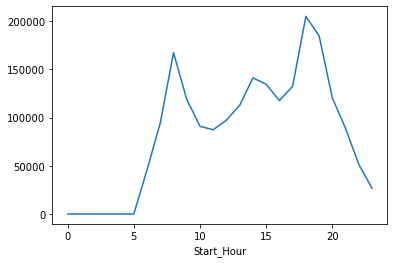

In [178]:
MiBici2017.loc[(MiBici2017['Start_Weekday'] != 'Saturday') & 
               (MiBici2017['Start_Weekday'] != 'Sunday')].groupby('Start_Hour').size().plot()

In [183]:
MiBici2017.loc[(MiBici2017['Start_Weekday'] != 'Saturday') & 
               (MiBici2017['Start_Weekday'] != 'Sunday')].groupby('Start_Hour').size()/(5*52)

Start_Hour
0       0.042308
1       0.011538
5       0.003846
6     176.400000
7     363.407692
8     643.084615
9     456.650000
10    349.330769
11    335.826923
12    374.303846
13    433.150000
14    542.688462
15    517.161538
16    452.023077
17    509.069231
18    787.784615
19    710.211538
20    462.996154
21    340.826923
22    197.907692
23    102.588462
dtype: float64

<AxesSubplot:xlabel='Start_Hour'>

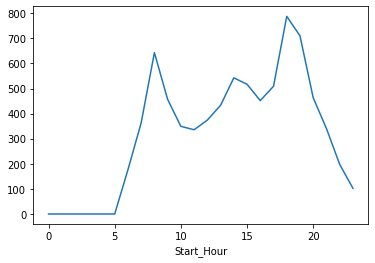

In [185]:
(MiBici2017.loc[(MiBici2017['Start_Weekday'] != 'Saturday') & 
               (MiBici2017['Start_Weekday'] != 'Sunday')].groupby('Start_Hour').size()/(5*52)).plot()

### Circular HeatMap

## Google Maps Popular Routes

In [ ]:
pd.concat([
MiBici2017.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15),
MiBici2018.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15),
MiBici2019.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15),
MiBici2020.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15),
MiBici2021.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15),
MiBici2022.groupby(["Start_Name","End_Name"]).size().reset_index(name = "Number of Trips").sort_values("Number of Trips", ascending = False).reset_index(drop=True).head(15)
], axis=0)

In [163]:
MiBici2017.groupby(["Start_Name","End_Name"]).count().reset_index()

,Start_Name,End_Name,Trip_ID,User_ID,Gender,Birth_Year,Age,Start_Time,End_Time,Start_Station_ID,...,Start_City,Start_Neighborhood,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood,Age_category
0,C. Donato Guerra /Av. La Paz,C. Donato Guerra /Av. La Paz,439,439,439,439,439,439,439,439,...,439,439,439,439,439,439,439,439,439,439
1,C. Donato Guerra /Av. La Paz,C. Juan Manuel / C. Andrés Terán,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75
2,C. Donato Guerra /Av. La Paz,C. Mariano Bárcena / Maestros,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
3,C. Donato Guerra /Av. La Paz,C. Relojeros/ C. Chamizal,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,C. Donato Guerra /Av. La Paz,Av Lázaro Cárdenas / Av San Ignacio,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33901,Salvador Quevedo/López Portillo,Calz. Indep. /C. Juan Manuel,166,166,166,166,166,166,166,166,...,166,166,166,166,166,166,166,166,166,166
33902,Salvador Quevedo/López Portillo,Calzada Federalismo / C. Vidrio,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
33903,Salvador Quevedo/López Portillo,J. Clemente Orozco /C. Jesús García,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
33904,Salvador Quevedo/López Portillo,Lopez Cotilla/ Marcos Castellanos,118,118,118,118,118,118,118,118,...,118,118,118,118,118,118,118,118,118,118


In [151]:
MiBici2017.groupby(["Start_Name","End_Name"]).size().sort_values(ascending=False).head(10)

Start_Name                            End_Name                            
 C. Juan Álvarez / C. Belén            C. Juan Álvarez / C. Belén             2953
                                       C. Monte Cáucaso / C. Sierra Nevada    2745
 C. Miguel Blanco / C. Penitenciaria   C. Miguel Blanco / C. Penitenciaria    2477
 Lopez Cotilla/ Marcos Castellanos     Lopez Cotilla/ Marcos Castellanos      2414
 C. Marsella / C. López Cotilla        Lopez Cotilla/ Marcos Castellanos      2328
 C. Colonias  / C. López Cotilla       Lopez Cotilla/ Marcos Castellanos      2226
 Lopez Cotilla/ Marcos Castellanos     C. Colonias  / C. López Cotilla        2216
 Calz. Federalismo/ C. J. Angulo       C. Juan Álvarez / C. Belén             2155
 C. Monte Cáucaso / C. Sierra Nevada   C. Juan Álvarez / C. Belén             2110
 Av. Juárez / Calz. Independencia      Av. Juárez / Av. 16 de Septiembre      1995
dtype: int64

In [156]:
MiBici2017.groupby(["Start_Name","End_Name"]).size().reset_index(drop=True).sort_values(ascending=False).head(10)

18079    2953
18101    2745
21613    2477
33445    2414
21055    2328
9633     2226
33304    2216
32130    2155
21946    2110
2709     1995
dtype: int64

In [160]:
MiBici2017.groupby(["Start_Name","End_Name"]).size().reset_index(drop=True).sort_values(ascending=False).head(10).index

Int64Index([18079, 18101, 21613, 33445, 21055, 9633, 33304, 32130, 21946,
            2709],
           dtype='int64')

In [161]:
MiBici2017.iloc[18079,:]

Trip_ID                                                         1897903
User_ID                                                           43115
Gender                                                                M
Birth_Year                                                       1991.0
Age                                                                26.0
Start_Time                                          2017-01-12 21:52:01
End_Time                                            2017-01-12 21:55:34
Start_Station_ID                                                     46
End_Station_ID                                                       21
Duration                                                           3.55
Start_Hour                                                           21
Start_Month                                                           1
Start_Weekday                                                  Thursday
Start_Name                           C. Gral. San Martín /Av.  V

In [159]:
MiBici2017.iloc[MiBici2017.groupby(["Start_Name","End_Name"]).size().reset_index(drop=True).sort_values(ascending=False).head(10).index,:]

,Trip_ID,User_ID,Gender,Birth_Year,Age,Start_Time,End_Time,Start_Station_ID,End_Station_ID,Duration,...,Start_Neighborhood,End_Name,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood,Age_category
18655,1897903,43115,M,1991.0,26.0,2017-01-12 21:52:01,2017-01-12 21:55:34,46,21,3.550000,...,Obrera,C. Juan Manuel / C. Andrés Terán,20.678835,-103.368045,IN_SERVICE,"20.678835,-103.368045","MiBici, Calle Juan Manuel, 44600, Calle Juan M...",Guadalajara,Santa Tere,20s
18677,1873430,55215,F,1989.0,28.0,2017-01-09 14:11:21,2017-01-09 14:17:06,48,21,5.750000,...,Americana,C. Juan Manuel / C. Andrés Terán,20.678835,-103.368045,IN_SERVICE,"20.678835,-103.368045","MiBici, Calle Juan Manuel, 44600, Calle Juan M...",Guadalajara,Santa Tere,20s
22324,1997260,7422,M,1949.0,68.0,2017-01-27 18:26:31,2017-01-27 18:49:11,25,25,22.666667,...,Capilla de Jesús,C. Jesús / C. San Felipe,20.679309,-103.356281,IN_SERVICE,"20.679309,-103.356281","Federico Froebel, 805, Calle San Felipe, 44100...",Guadalajara,Capilla de Jesús,60s
34520,1860112,134233,M,1980.0,37.0,2017-01-06 14:28:06,2017-01-06 14:37:29,60,35,9.383333,...,Las Nueve Esquinas,Av. Hidalgo / C. Pedro Loza,20.677419,-103.347983,IN_SERVICE,"20.677419,-103.347983","MiBici, Avenida Hidalgo, 44100, Avenida Hidalg...",Guadalajara,Guadalajara Centro,30s
21723,1907825,122114,M,1987.0,30.0,2017-01-14 17:06:12,2017-01-14 17:47:13,24,24,41.016667,...,Capilla de Jesús,C. San Felipe /C Enrique D. de León,20.679389,-103.359130,IN_SERVICE,"20.679389,-103.35913","936, Calle San Felipe, 44100, Calle San Felipe...",Guadalajara,Capilla de Jesús,20s
9917,1905490,126327,M,1988.0,29.0,2017-01-14 09:38:43,2017-01-14 09:45:40,60,12,6.950000,...,Las Nueve Esquinas,C. Cruz verde / C. Joaquin Angulo,20.681852,-103.357338,IN_SERVICE,"20.6818519,-103.3573381","MiBici, Calle Cruz Verde, 44200, Calle Cruz Ve...",Guadalajara,Capilla de Jesús,20s
34379,1841388,61372,M,1987.0,30.0,2017-01-03 14:35:13,2017-01-03 14:40:11,56,35,4.966667,...,San Juan de Dios,Av. Hidalgo / C. Pedro Loza,20.677419,-103.347983,IN_SERVICE,"20.677419,-103.347983","MiBici, Avenida Hidalgo, 44100, Avenida Hidalg...",Guadalajara,Guadalajara Centro,20s
33163,1938414,121476,M,1971.0,46.0,2017-01-19 12:28:44,2017-01-19 12:45:27,191,34,16.716667,...,Arcos Vallarta,C. Degollado / Av. Hidalgo,20.677263,-103.344908,IN_SERVICE,"20.6772627,-103.344908","MiBici, Paseo Collado, 44280, Paseo Collado, G...",Guadalajara,Guadalajara Centro,40s
22664,1869511,124625,F,1993.0,24.0,2017-01-08 16:25:13,2017-01-08 16:34:59,63,25,9.766667,...,Americana,C. Jesús / C. San Felipe,20.679309,-103.356281,IN_SERVICE,"20.679309,-103.356281","Federico Froebel, 805, Calle San Felipe, 44100...",Guadalajara,Capilla de Jesús,20s
2788,1960188,143000,M,1993.0,24.0,2017-01-23 08:49:41,2017-01-23 09:03:41,58,4,14.000000,...,Las Nueve Esquinas,C. Vidrio / Av. Chapultepec,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","Ui Internacional, 1984, Calle Vidrio, 44150, C...",Guadalajara,Obrera,20s


In [157]:
MiBici2017

,Trip_ID,User_ID,Gender,Birth_Year,Age,Start_Time,End_Time,Start_Station_ID,End_Station_ID,Duration,...,Start_Neighborhood,End_Name,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood,Age_category
0,1833214,145002,M,1992.0,25.0,2017-01-01 18:36:01,2017-01-01 18:51:41,2,2,15.666667,...,Mexicaltzingo,C. Epigmenio Glez./ Av. 16 de Sept.,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","MiBici, Calle Epigmenio González, 44180, Calle...",Guadalajara,Mexicaltzingo,20s
2,1849413,126715,M,1971.0,46.0,2017-01-04 19:03:15,2017-01-04 19:20:49,2,2,17.566667,...,Mexicaltzingo,C. Epigmenio Glez./ Av. 16 de Sept.,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","MiBici, Calle Epigmenio González, 44180, Calle...",Guadalajara,Mexicaltzingo,40s
4,1852599,26562,M,1965.0,52.0,2017-01-05 11:23:41,2017-01-05 11:33:52,2,2,10.183333,...,Mexicaltzingo,C. Epigmenio Glez./ Av. 16 de Sept.,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","MiBici, Calle Epigmenio González, 44180, Calle...",Guadalajara,Mexicaltzingo,50s
6,1859126,143556,M,1980.0,37.0,2017-01-06 11:43:40,2017-01-06 12:06:48,2,2,23.133333,...,Mexicaltzingo,C. Epigmenio Glez./ Av. 16 de Sept.,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","MiBici, Calle Epigmenio González, 44180, Calle...",Guadalajara,Mexicaltzingo,30s
7,1863126,101164,M,1998.0,19.0,2017-01-06 21:38:23,2017-01-06 22:07:33,2,2,29.166667,...,Mexicaltzingo,C. Epigmenio Glez./ Av. 16 de Sept.,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","MiBici, Calle Epigmenio González, 44180, Calle...",Guadalajara,Mexicaltzingo,<20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198441,4750279,147100,F,1997.0,20.0,2017-12-26 13:27:50,2017-12-26 13:42:13,243,253,14.383333,...,Vallarta Cuauhtémoc,C. Duque de Rivas/ C. López Cotilla,20.673168,-103.382689,IN_SERVICE,"20.6731682,-103.3826893","2139, Calle López Cotilla, 44130, Calle López ...",Guadalajara,Arcos Vallarta,<20
198442,4750265,233010,M,1992.0,25.0,2017-12-26 13:24:58,2017-12-26 13:45:12,253,253,20.233333,...,Arcos Vallarta,C. Duque de Rivas/ C. López Cotilla,20.673168,-103.382689,IN_SERVICE,"20.6731682,-103.3826893","2139, Calle López Cotilla, 44130, Calle López ...",Guadalajara,Arcos Vallarta,20s
198443,4751973,227777,M,1977.0,40.0,2017-12-26 17:27:49,2017-12-26 17:38:20,253,253,10.516667,...,Arcos Vallarta,C. Duque de Rivas/ C. López Cotilla,20.673168,-103.382689,IN_SERVICE,"20.6731682,-103.3826893","2139, Calle López Cotilla, 44130, Calle López ...",Guadalajara,Arcos Vallarta,30s
198444,4767170,15557,F,1981.0,36.0,2017-12-28 19:07:49,2017-12-28 19:21:21,253,253,13.533333,...,Arcos Vallarta,C. Duque de Rivas/ C. López Cotilla,20.673168,-103.382689,IN_SERVICE,"20.6731682,-103.3826893","2139, Calle López Cotilla, 44130, Calle López ...",Guadalajara,Arcos Vallarta,30s


In [158]:
MiBici2017.groupby(["Start_Name","End_Name"]).count().sort_values(by=["Start_Name","End_Name"], axis = 0).iloc[0]

Trip_ID               439
User_ID               439
Gender                439
Birth_Year            439
Age                   439
Start_Time            439
End_Time              439
Start_Station_ID      439
End_Station_ID        439
Duration              439
Start_Hour            439
Start_Month           439
Start_Weekday         439
Start_Latitude        439
Start_Longitude       439
Start_Status          439
Start_Geometry        439
Start_Address         439
Start_City            439
Start_Neighborhood    439
End_Latitude          439
End_Longitude         439
End_Status            439
End_Geometry          439
End_Address           439
End_City              439
End_Neighborhood      439
Age_category          439
Name: (  C. Donato Guerra /Av. La Paz,   C. Donato Guerra /Av. La Paz), dtype: int64